## Try out using pyramid (python auto arima package) against facebook prophet
* We'll use this data set: https://fred.stlouisfed.org/series/IPG2211A2N
    * It's monthly industrial production of electic and gas utilities in the US between 1985 and 2018.

In [1]:
# Import modules

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.plotly as ply
import cufflinks
from pyramid.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, mean_squared_error
from fbprophet import Prophet

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/pyramid/__init__.py:68: UserWarning:


    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    



In [2]:
# Set pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000

In [3]:
plt.style.use('seaborn')

## Useful functions

In [4]:
def check_stationarity(df, confidence_level):
    # This function tests the stationarity of the input time series up to a specified 
    # confidence level.
    dftest = adfuller(df.iloc[:, 0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    return dfoutput

In [5]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:, 0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [6]:
df = pd.read_csv('IPG2211A2N.csv', index_col=0)

In [7]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.6803
1985-02-01,70.8479
1985-03-01,62.6166
1985-04-01,57.6106
1985-05-01,55.4467


In [8]:
df.shape

(407, 1)

In [9]:
df.index.max()

'2018-11-01'

In [10]:
df.index.min()

'1985-01-01'

In [11]:
# Convert these to datatime 
df.index = pd.to_datetime(df.index)

In [12]:
df.index.max()

Timestamp('2018-11-01 00:00:00')

In [13]:
df.index.min()

Timestamp('1985-01-01 00:00:00')

In [14]:
# Rename the numerical column
df.columns = ['Energy production']

In [15]:
# Let's plot this and see what we are dealing with.
df.iplot(title='Energy production: January 1985 to November 2018')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~okeeffed090/0 or inside your plot.ly account where it is named 'Energy production: January 1985 to November 2018'


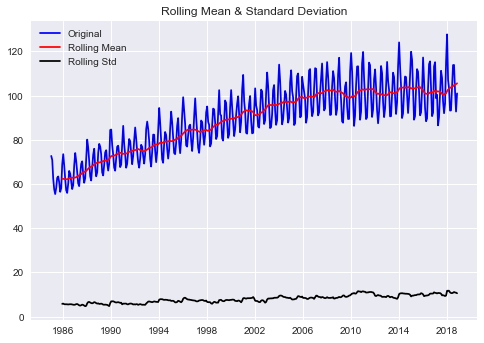

Results of Dickey-Fuller Test:
Test Statistic                  -2.307015
p-value                          0.169716
#Lags Used                      15.000000
Number of Observations Used    391.000000
Critical Value (5%)             -2.868960
Critical Value (1%)             -3.447186
Critical Value (10%)            -2.570723
dtype: float64


In [20]:
# Is this a stationary time series? We'll check with the dickey-fuller test, as well as look for seasonality.
test_stationarity(timeseries=df, window=12)

In [21]:
# In this case, we can't accept the alternative hypothesis, so the time series is nonstationary.  (Recall, the null hypothesis here is that the time series can be represented by
# a unit root, that is it's not stationary). The alternate hypothesis is that the time series cannot be represented by a unit root, so it's stationary.

In [22]:
# What about seasonality?
seasonal_result = seasonal_decompose(df, model='multiplicative')

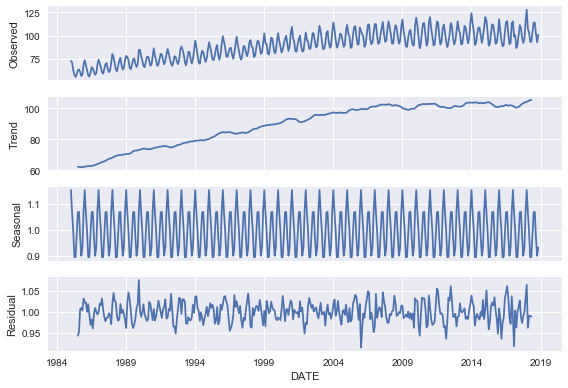

In [23]:
fig = seasonal_result.plot()

So there is definitely an upward trend.  There also looks to be a seasonal component due to the periodic seasonal behaviour. We'll account for the seasonality by using a seasonal arima model. As for the trend, we could pre-difference the data and fit the sarima to the difference data, or we could let the auto arima decide on the value of d in the model. We'll try the latter. This will make it easier to get estimations on the original undifferenced data. Otherwise, we could estimate the number of differences required, do them, and then build an ARMA model and forecast on the differenced data.   

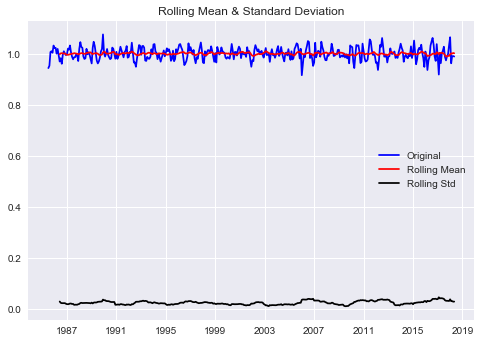

Results of Dickey-Fuller Test:
Test Statistic                -1.002166e+01
p-value                        1.672775e-17
#Lags Used                     1.400000e+01
Number of Observations Used    3.800000e+02
Critical Value (5%)           -2.869176e+00
Critical Value (1%)           -3.447676e+00
Critical Value (10%)          -2.570838e+00
dtype: float64


In [24]:
test_stationarity(seasonal_result.resid.dropna(), window=12)

In [26]:
# Fit a seasonal arima model to the original data and we'll let auto_arima pick the right parameters.
# We'll train on the first 20 years of data and use the rest for testing.

In [27]:
train_df = df.loc['1985-01-01': '2016-12-01']
test_df = df.loc['2017-01-01':]

In [28]:
# Define the model. I expect a seasonality of one year, so m=12 in the model to define the period for seasonal differencing.
stepwise_model = auto_arima(train_df, 
                            start_p=1, 
                            start_q=1,
                            max_p=3, 
                            max_q=3,
                            max_d=2,
                            m=12,
                            start_P=0, 
                            seasonal=True,
                            d=None, 
                            D=1, 
                            trace=True,
                            error_action='ignore',  
                            suppress_warnings=True, 
                            stepwise=True)

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning:

internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.



Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1694.776, BIC=1714.357, Fit time=3.019 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=1903.988, BIC=1911.821, Fit time=0.038 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=1845.096, BIC=1860.761, Fit time=0.719 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=1752.195, BIC=1767.860, Fit time=0.726 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=1695.399, BIC=1718.896, Fit time=5.173 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=1820.701, BIC=1836.366, Fit time=0.797 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1694.519, BIC=1718.016, Fit time=6.786 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1751.725, BIC=1771.306, Fit time=2.543 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=1694.642, BIC=1722.056, Fit time=8.091 seconds
Fit ARIMA: order=(1, 1, 0) s

In [29]:
test_df.shape

(23, 1)

In [30]:
# The AIC of the best model is:
stepwise_model.aic()

1686.2670996090328

In [31]:
forecast_results = stepwise_model.predict(n_periods=23)

In [32]:
forecast_df = pd.DataFrame(forecast_results, index=test_df.index, columns=['Predictions'])

In [33]:
forecast_df = pd.concat([test_df, forecast_df], axis=1)

In [34]:
forecast_df

,Energy production,Predictions
DATE,,
2017-01-01,115.1100,121.555936
2017-02-01,98.7900,109.592520
2017-03-01,100.3838,99.844850
2017-04-01,86.5178,89.775170
2017-05-01,90.2272,91.339952
2017-06-01,100.5536,102.664223
2017-07-01,111.2244,112.173972
2017-08-01,108.0286,111.898974
2017-09-01,97.2464,100.561314


In [35]:
# How did we do?
r2_auto_arima = r2_score(y_pred=forecast_df['Predictions'].values, y_true=forecast_df['Energy production'])
mse_auto_arima = mean_squared_error(y_pred=forecast_df['Predictions'].values, y_true=forecast_df['Energy production'])
rmse_auto_arima = np.sqrt(mse_auto_arima)

In [36]:
r2_auto_arima

0.8320420523247696

In [37]:
mse_auto_arima

16.11038622815135

In [38]:
rmse_auto_arima

4.01377456120188

In [39]:
# Not horrible actually.
forecast_df.iplot()

In [40]:
forecast_plus_original_df = pd.concat([df, pd.DataFrame(forecast_results, index=test_df.index, columns=['Predictions'])], axis=1)

In [41]:
forecast_plus_original_df.iplot()

## Compare to fbprophet

In [42]:
prophet_model = Prophet(seasonality_mode='multiplicative')

In [43]:
df_prophet = df.copy()

In [44]:
df_prophet.index.name = 'ds'

In [45]:
df_prophet.columns = ['y']

In [46]:
df_prophet.reset_index(inplace=True)

In [47]:
df_prophet.head()

,ds,y
0,1985-01-01,72.6803
1,1985-02-01,70.8479
2,1985-03-01,62.6166
3,1985-04-01,57.6106
4,1985-05-01,55.4467


In [48]:
prophet_train_df = df_prophet.loc[(df_prophet['ds'] <= '2016-12-01')]
prophet_test_df = df_prophet.loc[(df_prophet['ds'] >= '2017-01-01')]

In [49]:
prophet_model.fit(prophet_train_df)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [50]:
prophet_future_df = prophet_model.make_future_dataframe(periods=23, freq='M')

In [51]:
prophet_forecast_df = prophet_model.predict(prophet_future_df)

In [52]:
prophet_forecast_df.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
0,1985-01-01,61.283027,61.283027,61.283027,66.987371,73.098253,0.0,0.0,0.0,0.145970,0.145970,0.145970,0.145970,0.145970,0.145970,70.228517
1,1985-02-01,61.469098,61.469098,61.469098,62.207275,68.184266,0.0,0.0,0.0,0.059781,0.059781,0.059781,0.059781,0.059781,0.059781,65.143796
2,1985-03-01,61.637162,61.637162,61.637162,57.749194,63.846133,0.0,0.0,0.0,-0.011520,-0.011520,-0.011520,-0.011520,-0.011520,-0.011520,60.927091
3,1985-04-01,61.823232,61.823232,61.823232,52.161761,58.201611,0.0,0.0,0.0,-0.107483,-0.107483,-0.107483,-0.107483,-0.107483,-0.107483,55.178288
4,1985-05-01,62.003300,62.003300,62.003300,52.534249,58.645010,0.0,0.0,0.0,-0.103534,-0.103534,-0.103534,-0.103534,-0.103534,-0.103534,55.583866


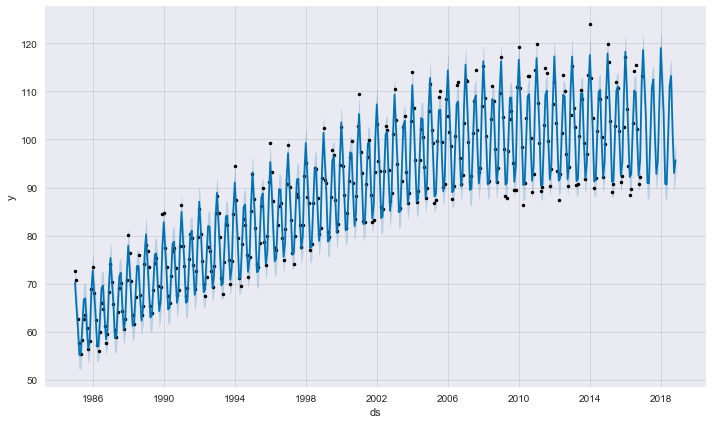

In [53]:
fig1 = prophet_model.plot(prophet_forecast_df)

In [54]:
prophet_forecast_df.tail(30)

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
377,2016-06-01,103.014398,103.014398,103.014398,99.061904,105.294632,0.0,0.0,0.0,-0.009100,-0.009100,-0.009100,-0.009100,-0.009100,-0.009100,102.076937
378,2016-07-01,103.031732,103.031732,103.031732,106.889213,113.339621,0.0,0.0,0.0,0.069346,0.069346,0.069346,0.069346,0.069346,0.069346,110.176610
379,2016-08-01,103.049643,103.049643,103.049643,106.652099,112.830754,0.0,0.0,0.0,0.065477,0.065477,0.065477,0.065477,0.065477,0.065477,109.797004
380,2016-09-01,103.067555,103.067555,103.067555,96.667761,102.867547,0.0,0.0,0.0,-0.031381,-0.031381,-0.031381,-0.031381,-0.031381,-0.031381,99.833173
381,2016-10-01,103.084889,103.084889,103.084889,89.360802,95.246500,0.0,0.0,0.0,-0.103356,-0.103356,-0.103356,-0.103356,-0.103356,-0.103356,92.430476
382,2016-11-01,103.102800,103.102800,103.102800,92.690849,98.831475,0.0,0.0,0.0,-0.071402,-0.071402,-0.071402,-0.071402,-0.071402,-0.071402,95.741023
383,2016-12-01,103.120134,103.120134,103.120134,108.475467,114.716931,0.0,0.0,0.0,0.081124,0.081124,0.081124,0.081124,0.081124,0.081124,111.485689
384,2016-12-31,103.137468,103.137468,103.137468,115.569313,121.741147,0.0,0.0,0.0,0.150014,0.150014,0.150014,0.150014,0.150014,0.150014,118.609518
385,2017-01-31,103.155379,103.155379,103.155379,107.921987,114.187105,0.0,0.0,0.0,0.076499,0.076499,0.076499,0.076499,0.076499,0.076499,111.046624
386,2017-02-28,103.171558,103.171558,103.171558,101.063415,107.393740,0.0,0.0,0.0,0.010428,0.010428,0.010428,0.010428,0.010428,0.010428,104.247387


In [55]:
# Ok let's see how this compares to the actual values...
prophet_forecast_compare_df = prophet_forecast_df.loc[(prophet_forecast_df['ds'] >= '2016-12-31')]

In [56]:
prophet_forecast_compare_df.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,yhat
384,2016-12-31,103.137468,103.137468,103.137468,115.569313,121.741147,0.0,0.0,0.0,0.150014,0.150014,0.150014,0.150014,0.150014,0.150014,118.609518
385,2017-01-31,103.155379,103.155379,103.155379,107.921987,114.187105,0.0,0.0,0.0,0.076499,0.076499,0.076499,0.076499,0.076499,0.076499,111.046624
386,2017-02-28,103.171558,103.171558,103.171558,101.063415,107.393740,0.0,0.0,0.0,0.010428,0.010428,0.010428,0.010428,0.010428,0.010428,104.247387
387,2017-03-31,103.189469,103.188622,103.189566,87.812686,93.991425,0.0,0.0,0.0,-0.119024,-0.119024,-0.119024,-0.119024,-0.119024,-0.119024,90.907488
388,2017-04-30,103.206803,103.204250,103.208911,87.626642,94.142624,0.0,0.0,0.0,-0.119745,-0.119745,-0.119745,-0.119745,-0.119745,-0.119745,90.848305


In [57]:
# That's annoying...the months end at a different day.
prophet_test_df['ds'].iloc[0]

Timestamp('2017-01-01 00:00:00')

In [58]:
prophet_test_df['ds'] = prophet_test_df['ds'] - pd.tseries.offsets.MonthEnd()

In [59]:
prophet_test_df.head()

,ds,y
384,2016-12-31,115.1100
385,2017-01-31,98.7900
386,2017-02-28,100.3838
387,2017-03-31,86.5178
388,2017-04-30,90.2272


In [60]:
prophet_test_df['Prediction'] = prophet_forecast_compare_df['yhat']

In [61]:
prophet_test_df.head()

,ds,y,Prediction
384,2016-12-31,115.1100,118.609518
385,2017-01-31,98.7900,111.046624
386,2017-02-28,100.3838,104.247387
387,2017-03-31,86.5178,90.907488
388,2017-04-30,90.2272,90.848305


In [62]:
r2_prophet = r2_score(y_pred=prophet_test_df['Prediction'], y_true=prophet_test_df['y'])
mse_prophet = mean_squared_error(y_pred=prophet_test_df['Prediction'], y_true=prophet_test_df['y'])
rmse_prophet = np.sqrt(mse_prophet)

In [63]:
r2_prophet

0.7947484616482199

In [64]:
mse_prophet

19.687556335013788

In [65]:
rmse_prophet

4.4370661855570495

In [66]:
prophet_test_df.set_index('ds', inplace=True)

In [67]:
prophet_test_df.iplot()

In [69]:
# Let's visualize the difference in both sets of predictions.
prophet_test_df.index.name = 'DATE'

In [70]:
prophet_test_df.index = pd.to_datetime(prophet_test_df.index)

In [72]:
prophet_test_df.index = prophet_test_df.index + pd.tseries.offsets.DateOffset()

In [73]:
prophet_test_df.columns = ['Energy production', 'Prophet_prediction']

In [74]:
forecast_df.columns = ['Energy production', 'auto_arima_prediction']

In [75]:
compare_prophet_auto_arima_df = pd.concat([forecast_df, prophet_test_df.drop('Energy production', axis=1)], axis=1)

In [76]:
compare_prophet_auto_arima_df.iplot()

In [ ]:
# The two model look pretty comparable at the surface.  We'll dig into this more later.